In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [2]:
# data = pd.read_json('/Users/yuhanqi/MA/code/data/2011_2019_time_series_for_forecasting_Tampa_Tucson.json')
data = pd.read_json('/Users/yuhanqi/MA/code/data/2011_2019_time_series_for_forecasting_Indianapolis_Reno_Santa_Barbara_Saint_Louis_Boise.json')

In [3]:
city = 'Boise'

In [4]:
data_df = data[data.filter(like=city).columns].drop(['bsi_{}_stars'.format(city), 'asi_{}_stars'.format(city), 'vsi_{}_stars'.format(city)], axis = 1)
data_df['date'] = pd.to_datetime(data['date'])
data_df = data_df.drop(range(418,472), axis = 0)

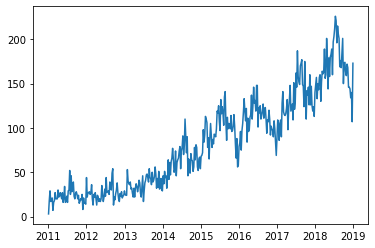

In [5]:
plt.plot(data_df['date'], data_df['count_{}'.format(city)])

In [6]:
def si_plot(df, y_min, y_max, ylabel, loc):
    plot = df.set_index('date') 
    plot.loc[:, plot.columns].plot(label='stars',  marker='o'
                                            , color=['green', 'orange', 'purple'], figsize=(12,4))
    #plot.stars.plot(marker='o', color=['blue'], lw=5, alpha=0.5)
    plt.ylim(y_min, y_max)
    # adding title
    # plt.title('BSI Time Series of Sentiment (Star Rating) - 2019', fontsize=16)
    # adding label to x-axis
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    # adding legend.
    plt.legend(loc=loc)

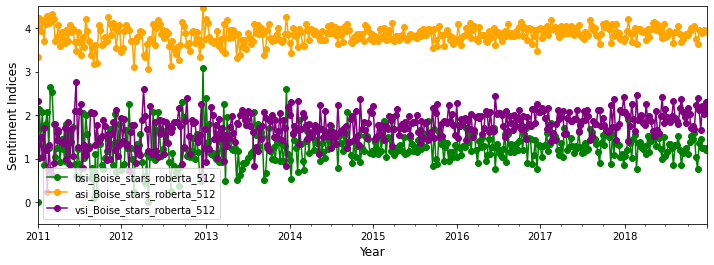

In [7]:
plot_df = data_df[['date','bsi_{}_stars_roberta_512'.format(city),'asi_{}_stars_roberta_512'.format(city),'vsi_{}_stars_roberta_512'.format(city)]]
si_plot(plot_df, -0.5, 4.5, 'Sentiment Indices', 'lower left')

The blue area depicts the 95% confidence interval and is an indicator of the signifcance threshold. Anything in the blue are is statistically close to 0.
1. A slow decay of ACF indicates data non-stationarity.
2. Both show geometric decay, this indicates that both p and q are non-zero, ACF and PACF don't help and the hyperparameters need to be selected in other ways.

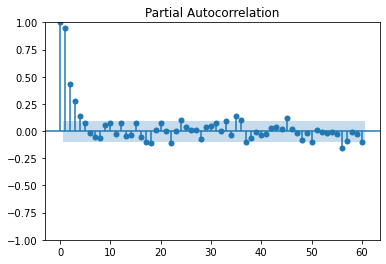

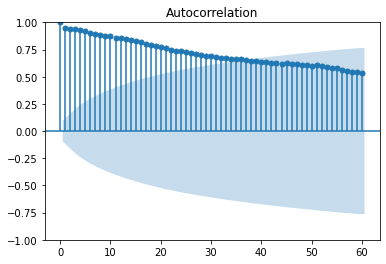

In [8]:
plot_pacf(data_df['count_{}'.format(city)], lags = 60);
plot_acf(data_df['count_{}'.format(city)], lags = 60);

p-value is large, cannot reject null and the time series may have a unit root, meaning non-stationary

In [9]:
ad_fuller_result = adfuller(data_df['count_{}'.format(city)])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.077804164172489
p-value: 0.7238417048263501


In [10]:
count = data_df['count_{}'.format(city)].diff()
#Seasonal differencing
count = count.diff(52)

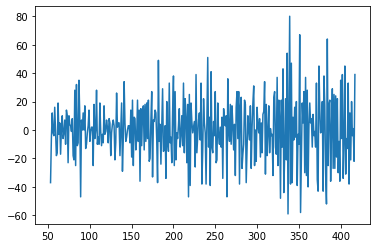

In [11]:
plt.plot(count)

In [12]:
def optimize_SARIMA(parameters_list, s, endog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        parameters_list - list with (p, d, q, P, D, Q) tuples
        s - length of season (52 for weekly data)
        endog - the endogenous variable
        exog - the exogenous variables as an array
    """
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(endog, order=(param[0], param[1], param[2]), seasonal_order=(param[3], param[4], param[5], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        print('(p,d,q)x(P,D,Q): ', param, ', AIC: ', aic)
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,d,q)x(P,D,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [13]:
p = range(0, 2)
d = range(1, 3)
q = range(1, 3)
P = range(0, 2)
D = range(1, 3)
Q = range(1, 3)
s = 52
parameters = product(p, d, q, P, D, Q)
parameters_list = list(parameters)
print(len(parameters_list))

64


In [14]:
result_df = optimize_SARIMA(parameters_list, 52, data_df['count_{}'.format(city)])

  0%|          | 0/64 [00:00<?, ?it/s]

(p,d,q)x(P,D,Q):  (0, 1, 1, 0, 1, 1) , AIC:  3023.445274747185
(p,d,q)x(P,D,Q):  (0, 1, 1, 0, 1, 2) , AIC:  3025.1913404094894
(p,d,q)x(P,D,Q):  (0, 1, 1, 0, 2, 1) , AIC:  2833.6402748500423
(p,d,q)x(P,D,Q):  (0, 1, 1, 0, 2, 2) , AIC:  2787.0231194939956
(p,d,q)x(P,D,Q):  (0, 1, 1, 1, 1, 1) , AIC:  3025.214849284511
(p,d,q)x(P,D,Q):  (0, 1, 1, 1, 1, 2) , AIC:  3027.116375452829
(p,d,q)x(P,D,Q):  (0, 1, 1, 1, 2, 1) , AIC:  2799.1201836963282
(p,d,q)x(P,D,Q):  (0, 1, 1, 1, 2, 2) , AIC:  2787.8603033348545
(p,d,q)x(P,D,Q):  (0, 1, 2, 0, 1, 1) , AIC:  3024.939718965071
(p,d,q)x(P,D,Q):  (0, 1, 2, 0, 1, 2) , AIC:  3026.7772293906887
(p,d,q)x(P,D,Q):  (0, 1, 2, 0, 2, 1) , AIC:  2834.8827144880024
(p,d,q)x(P,D,Q):  (0, 1, 2, 0, 2, 2) , AIC:  2786.671021715152
(p,d,q)x(P,D,Q):  (0, 1, 2, 1, 1, 1) , AIC:  3026.7914493438197
(p,d,q)x(P,D,Q):  (0, 1, 2, 1, 1, 2) , AIC:  3028.7219664128625
(p,d,q)x(P,D,Q):  (0, 1, 2, 1, 2, 1) , AIC:  2798.2367289088425
(p,d,q)x(P,D,Q):  (0, 1, 2, 1, 2, 2) , AIC:  

In [15]:
result_df.to_csv('/Users/yuhanqi/MA/code/SARIMA_AIC_{}.csv'.format(city), index = False)

In [52]:
best_model = SARIMAX(data_df['count_{}'.format(city)], order = (0,1,1), seasonal_order = (0,2,2,52)).fit(dis=-1, disp=-1)
print(best_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                             count_Boise   No. Observations:                  418
Model:             SARIMAX(0, 1, 1)x(0, 2, [1, 2], 52)   Log Likelihood               -1389.512
Date:                                 Sat, 24 Sep 2022   AIC                           2787.023
Time:                                         00:10:32   BIC                           2802.008
Sample:                                              0   HQIC                          2793.011
                                                 - 418                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8095      0.033    -24.274      0.000      -0.875      -0

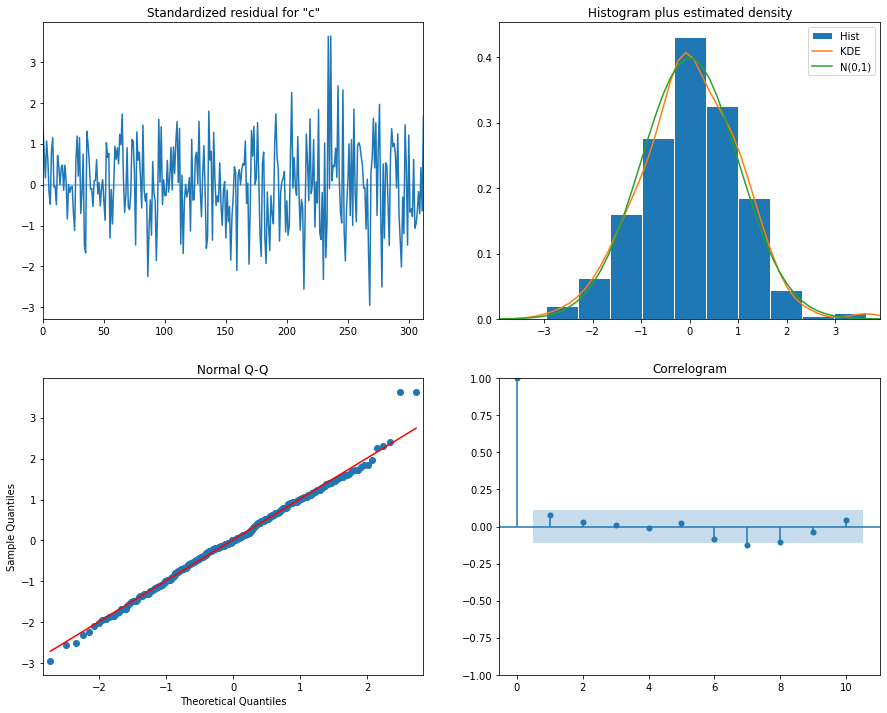

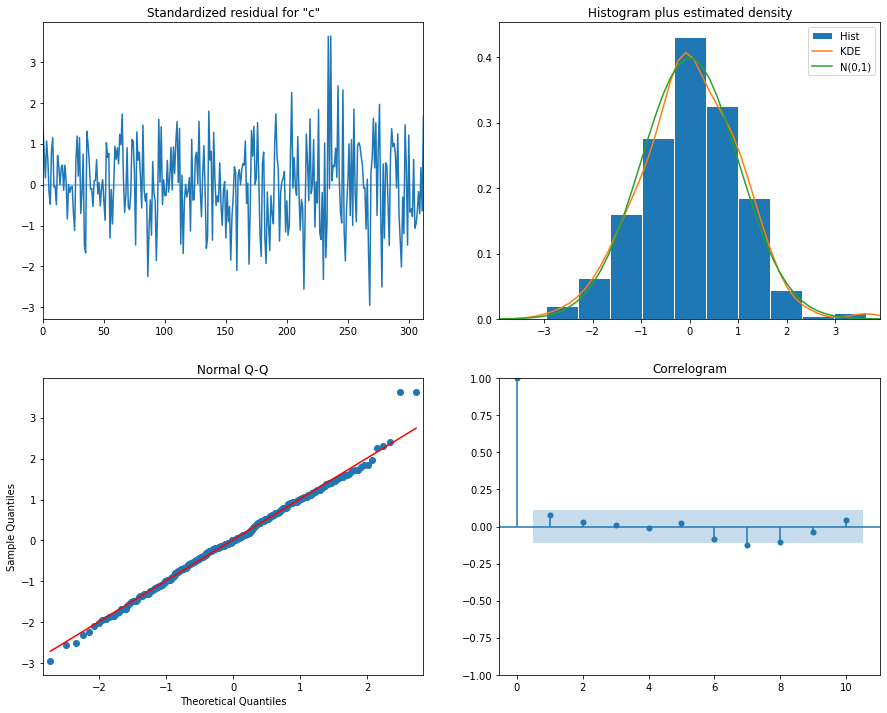

In [53]:
best_model.plot_diagnostics(figsize=(15,12))

In [54]:
data_forecast = data[data.filter(like=city).columns].drop(['bsi_{}_stars'.format(city), 'asi_{}_stars'.format(city), 'vsi_{}_stars'.format(city)], axis = 1)
data_forecast['date'] = pd.to_datetime(data['date'])
data_forecast = data_forecast.drop(range(0,418), axis = 0)
y_pred = best_model.forecast(steps=54, start_index = 418, end_index = 418+54)
data_df['predicted_{}'.format(city)] = np.NaN
forecast = data.copy()
forecast['predicted_{}_count_SARIMA'.format(city)] = data_df['predicted_{}'.format(city)].append(y_pred)

In [55]:
def plot_forecast(df, data_type, city):
    plt.plot(forecast['date'], forecast['{}_{}'.format(data_type, city)],label='{}_{}'.format(data_type, city))
    plt.plot(forecast['date'], forecast['predicted_{}_count_SARIMA'.format(city)], label='predicted_{}_SARIMA'.format(data_type, city))
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Review Volume', fontsize=12)
    plt.legend()
    plt.show()

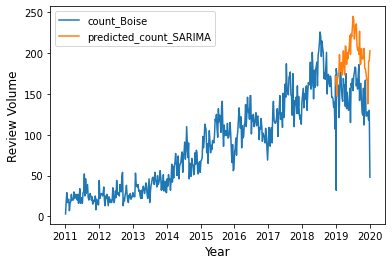

In [56]:
plot_forecast(forecast, 'count', city)

In [57]:
rmse = mean_squared_error(data_forecast['count_{}'.format(city)], y_pred, squared=False)
mape = mean_absolute_percentage_error(data_forecast['count_{}'.format(city)], y_pred)

In [58]:
print('RMSE: ', rmse)
print('MAPE: ', mape)
#(0,1,1,0,2,2)

RMSE:  57.913460858841454
MAPE:  0.4459167112830867


In [59]:
forecast_df = pd.read_json('/Users/yuhanqi/MA/code/data/2011_2019_SARIMAX_SARIMA_ETS_volume_Philadelphia_New Orleans_Nashville_Tampa_Tucson_Indianapolis_Reno_Santa_Barbara_Saint_Louis_Boise.json')
forecast_df['predicted_{}_count_SARIMA'.format(city)] = forecast['predicted_{}_count_SARIMA'.format(city)]

In [60]:
forecast_df.columns

Index(['date', 'predicted_Philadelphia_count_SARIMAX_roberta',
       'predicted_Philadelphia_count_SARIMA',
       'predicted_New Orleans_count_SARIMAX_roberta',
       'predicted_New Orleans_count_SARIMA',
       'predicted_Nashville_count_SARIMAX_roberta',
       'predicted_Nashville_count_SARIMA',
       'predicted_Philadelphia_count_Holt-Winters',
       'predicted_New Orleans_count_Holt-Winters',
       'predicted_Nashville_count_Holt-Winters',
       'predicted_Tampa_count_Holt-Winters',
       'predicted_Tucson_count_Holt-Winters',
       'predicted_Tampa_count_SARIMAX_roberta',
       'predicted_Tucson_count_SARIMAX_roberta',
       'predicted_Tampa_count_SARIMA', 'predicted_Philadelphia_count_SARIMAX',
       'predicted_Tucson_count_SARIMA', 'predicted_New Orleans_count_SARIMAX',
       'predicted_Indianapolis_count_Holt-Winters',
       'predicted_Reno_count_Holt-Winters',
       'predicted_Santa Barbara_count_Holt-Winters',
       'predicted_Saint Louis_count_Holt-Winters',

In [61]:
forecast_df.to_json('/Users/yuhanqi/MA/code/data/2011_2019_SARIMAX_SARIMA_ETS_volume_Philadelphia_New Orleans_Nashville_Tampa_Tucson_Indianapolis_Reno_Santa_Barbara_Saint_Louis_Boise.json')